In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

import os
os.chdir('/home/raid/Desktop/Shubh/DLProject/experiments')

from helpers.trainer import Trainer

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [12]:
def whitening_transform(data):
    # Center the data (subtract mean)
    mean = torch.mean(data, dim=0, keepdim=True)
    centered_data = data - mean

    # Compute covariance matrix
    covariance_matrix = torch.matmul(centered_data.T, centered_data) / (centered_data.size(0) - 1)

    # Compute eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = torch.eig(covariance_matrix, eigenvectors=True)

    # Whitening transformation
    whitened_data = torch.matmul(torch.matmul(eigenvectors, torch.diag(1 / torch.sqrt(eigenvalues[:, 0]))), eigenvectors.T) @ centered_data.T
    
    return whitened_data.T

In [13]:
# Defining batch size as given on page 7 on Adam Research Paper
batch_size = 128    

# Calculate the number of workers to use for DataLoader
num_workers = 8

# transformations
transform = transforms.Compose([transforms.ToTensor()])

In [14]:
os.chdir('/home/raid/Desktop/Shubh/DLProject/experiments/models')

# Load CIFAR-10 dataset
trainset = datasets.CIFAR10(root='../../datasets/', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='../../datasets/', train=False, download=True, transform=transform)

# trainset = whitening_transform(trainset)
# testset = whitening_transform(testset)

# Create DataLoader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

Files already downloaded and verified
Files already downloaded and verified


In [15]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)  # 3 input channels, 64 output channels, 5x5 kernel
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, padding=2) # 64 input channels, 64 output channels, 5x5 kernel
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, padding=2) # 64 input channels, 128 output channels, 5x5 kernel

        self.fc1 = nn.Linear(128 * 3 * 3, 1000)  # 128 * 4 * 4 input features, 1000 output features
        self.fc2 = nn.Linear(1000, 10)  # 1000 input features, 10 output classes
        
    def forward(self, x):
        # Convolutional layers with ReLU activation
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        
        # Flatten the feature maps
        x = x.view(-1, 128 * 3 * 3)

        # Fully connected layers with ReLU activation
        x = F.relu(self.fc1(x))

        
        # Output layer with softmax activation
        x = self.fc2(x)
        x = F.softmax(x, dim=1)

        return x


In [16]:
criterion = nn.CrossEntropyLoss()
epochs = 200

optimizer = optim.Adam

In [17]:
model = CNN().to(device)
trainer = Trainer(model, criterion, optimizer)

head1, head2, head3 = 'EPOCHS', 'TRAIN LOSS', 'VAL LOSS'
print(f'{head1 :>6} {head2 :>25} {head3 :>25}')

trainer.train(trainloader, testloader, epochs)

EPOCHS                TRAIN LOSS                  VAL LOSS


    10        1.8068138272561076         1.830178841759887
    20        1.7447504460659173        1.7872081466867953
    30        1.7222419964992786        1.7877682130548018
    40        1.7298530971302706         1.788150355785708
    50        1.7583478524556855        1.8096415121344072
    60        1.7947421247696937        1.8226625632636155
    70        1.8481208704926473        1.8507279187818118
    80           1.8454761233781        1.8691217069384418
    90        1.8728654210829674        1.8952805663965926
   100        2.1752597581395103        2.0154441429089895
   110        2.0895724924628998        2.2238178675687768
   120        2.0398183740923166        1.9733433074589017
   130         2.152616595063368        2.1400041006788424
   140        2.3445188511363075        2.3449523056609722
   150        2.3445308397493094        2.3449523056609722
   160        2.3529821155626145        2.3030218896986563
   170         2.360403601775694        2.36126955249641

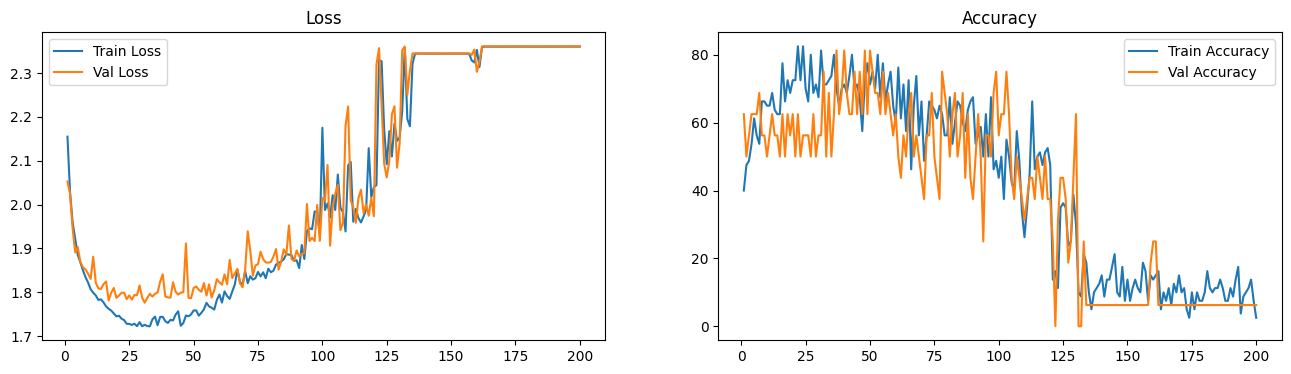

In [19]:
trainer.plot_graph()

In [20]:
loss_dict = {}

In [21]:
loss_dict['Adam (Pytorch)'] = trainer.train_loss